## Semirecursive Kernel Estimate

In [494]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import datetime

In [495]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

#### Classification Problem

In [496]:
Data = np.loadtxt('DataSheet_n=2^10_d=2.txt')
n0 = len(Data)
d = len(Data[1]) - 1
n = [1, 20, 50, n0//8]

labels = [1, 2, 3, 4]
m = len(labels)

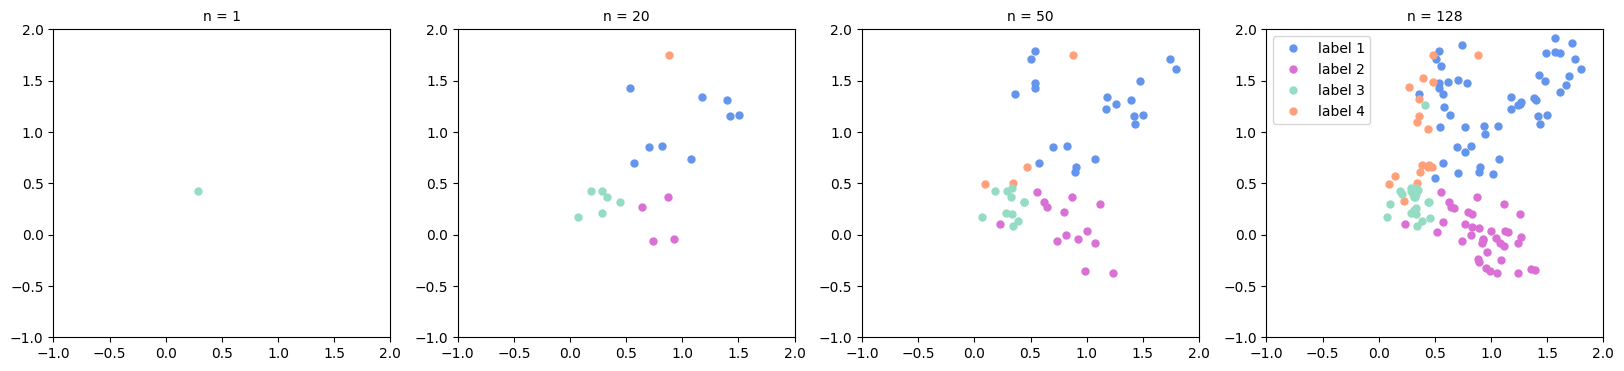

In [497]:
# plot of dataset

fig, axes = plt.subplots(1, len(n))

fig.set_figheight(4)
fig.set_figwidth(len(n)*5)

x = Data[:, 0]
y = Data[:, 1]
z = Data[:, 2]

labels_in_legend = ['_nolegend_', 'label 1', 'label 2', 'label 3', 'label 4']
bools_in_legend = [1, 0, 0, 0]

for idy in range(len(n)):
    for i in range(n[idy]):
        if z[i] == 1:
            axes[idy].plot(x[i], y[i], 'o', color = lighten_color('CornflowerBlue', 1), markersize = 5, label = labels_in_legend[1*bools_in_legend[0]])
            if idy == 3 and bools_in_legend[0] == 1:
                bools_in_legend[0] = 0
                bools_in_legend[1] = 1
        elif z[i] == 2:
            axes[idy].plot(x[i], y[i], 'o', color = lighten_color('Orchid', 1), markersize = 5, label = labels_in_legend[2*bools_in_legend[1]])
            if idy == 3 and bools_in_legend[1] == 1:
                bools_in_legend[1] = 0
                bools_in_legend[2] = 1
        elif z[i] == 3:
            axes[idy].plot(x[i], y[i], 'o', color = lighten_color('MediumAquamarine', 0.7), markersize = 5, label = labels_in_legend[3*bools_in_legend[2]])
            if idy == 3 and bools_in_legend[2] == 1:
                bools_in_legend[2] = 0
                bools_in_legend[3] = 1
        else:
            axes[idy].plot(x[i], y[i], 'o', color = lighten_color('LightSalmon', 1), markersize = 5, label = labels_in_legend[4*bools_in_legend[3]])
            if idy == 3 and bools_in_legend[3] == 1:
                bools_in_legend[3] = 0

for i in range(len(n)):
    axes[i].set_xlim(-1, 2)
    axes[i].set_ylim(-1, 2)

axes[3].legend(fontsize = 10)
axes[0].set_title('n = 1', fontsize = 10)
axes[1].set_title('n = 20', fontsize = 10)
axes[2].set_title('n = 50', fontsize = 10)
axes[3].set_title('n = 128', fontsize = 10)

plt.show()


In [498]:
# definition of naive kernel

def naivekernel(x):
    if np.linalg.norm(x) <= 1:
        value = 1
    else:
        value = 0

    return value

In [499]:
# computes the weight distribution of the Data within the bandwidth h of point

def weight(point, Data, h, n, bool):

    if bool == 0:

        return np.array([1, 1, 1, 1])
    
    elif bool == 1:
        
        weight = np.array([0.0, 0.0, 0.0, 0.0]) 
        for i in range(n):
            if np.linalg.norm((point-Data[i,0:d])/h) <= 1:
                Y = int(Data[i, d])
                weight[Y-1] = weight[Y-1] + 1  # account for index shift, since labels start at 1

        total = np.sum(weight)
        if total > 0:
            for i in range(len(weight)):
                weight[i] = weight[i] / total
        return weight


In [500]:
# definition of (weighted) semi-recursive kernel estimate

def kernelestimate(point, Data, h, kernel, n, bool):
    numerator = 0
    denominator = 0

    for i in range(n):
        alpha = weight(point, Data, h[i], n, bool)
        numerator += alpha[int(Data[i,d]) - 1]*kernel((point-Data[i,0:d])/h[i])*Data[i,d]
        denominator += kernel((point-Data[i,0:d])/h[i])
        
    if denominator > 0:
        return numerator / denominator
    else:
        return 0

In [501]:
# definition of two sequences of bandwidths

def diverging_series(int):

    ds =  np.zeros(n0)

    for i in range(n0):
        ds[i] = int*(1/math.sqrt(i+1))

    return ds

def converging_series(int):

    cs = np.zeros(n0)

    for i in range(n0):
        cs[i] = int*(1/pow(i+1,2))

    return cs

##### Semirecursive Kernel Estimate for different sequences of bandwidths

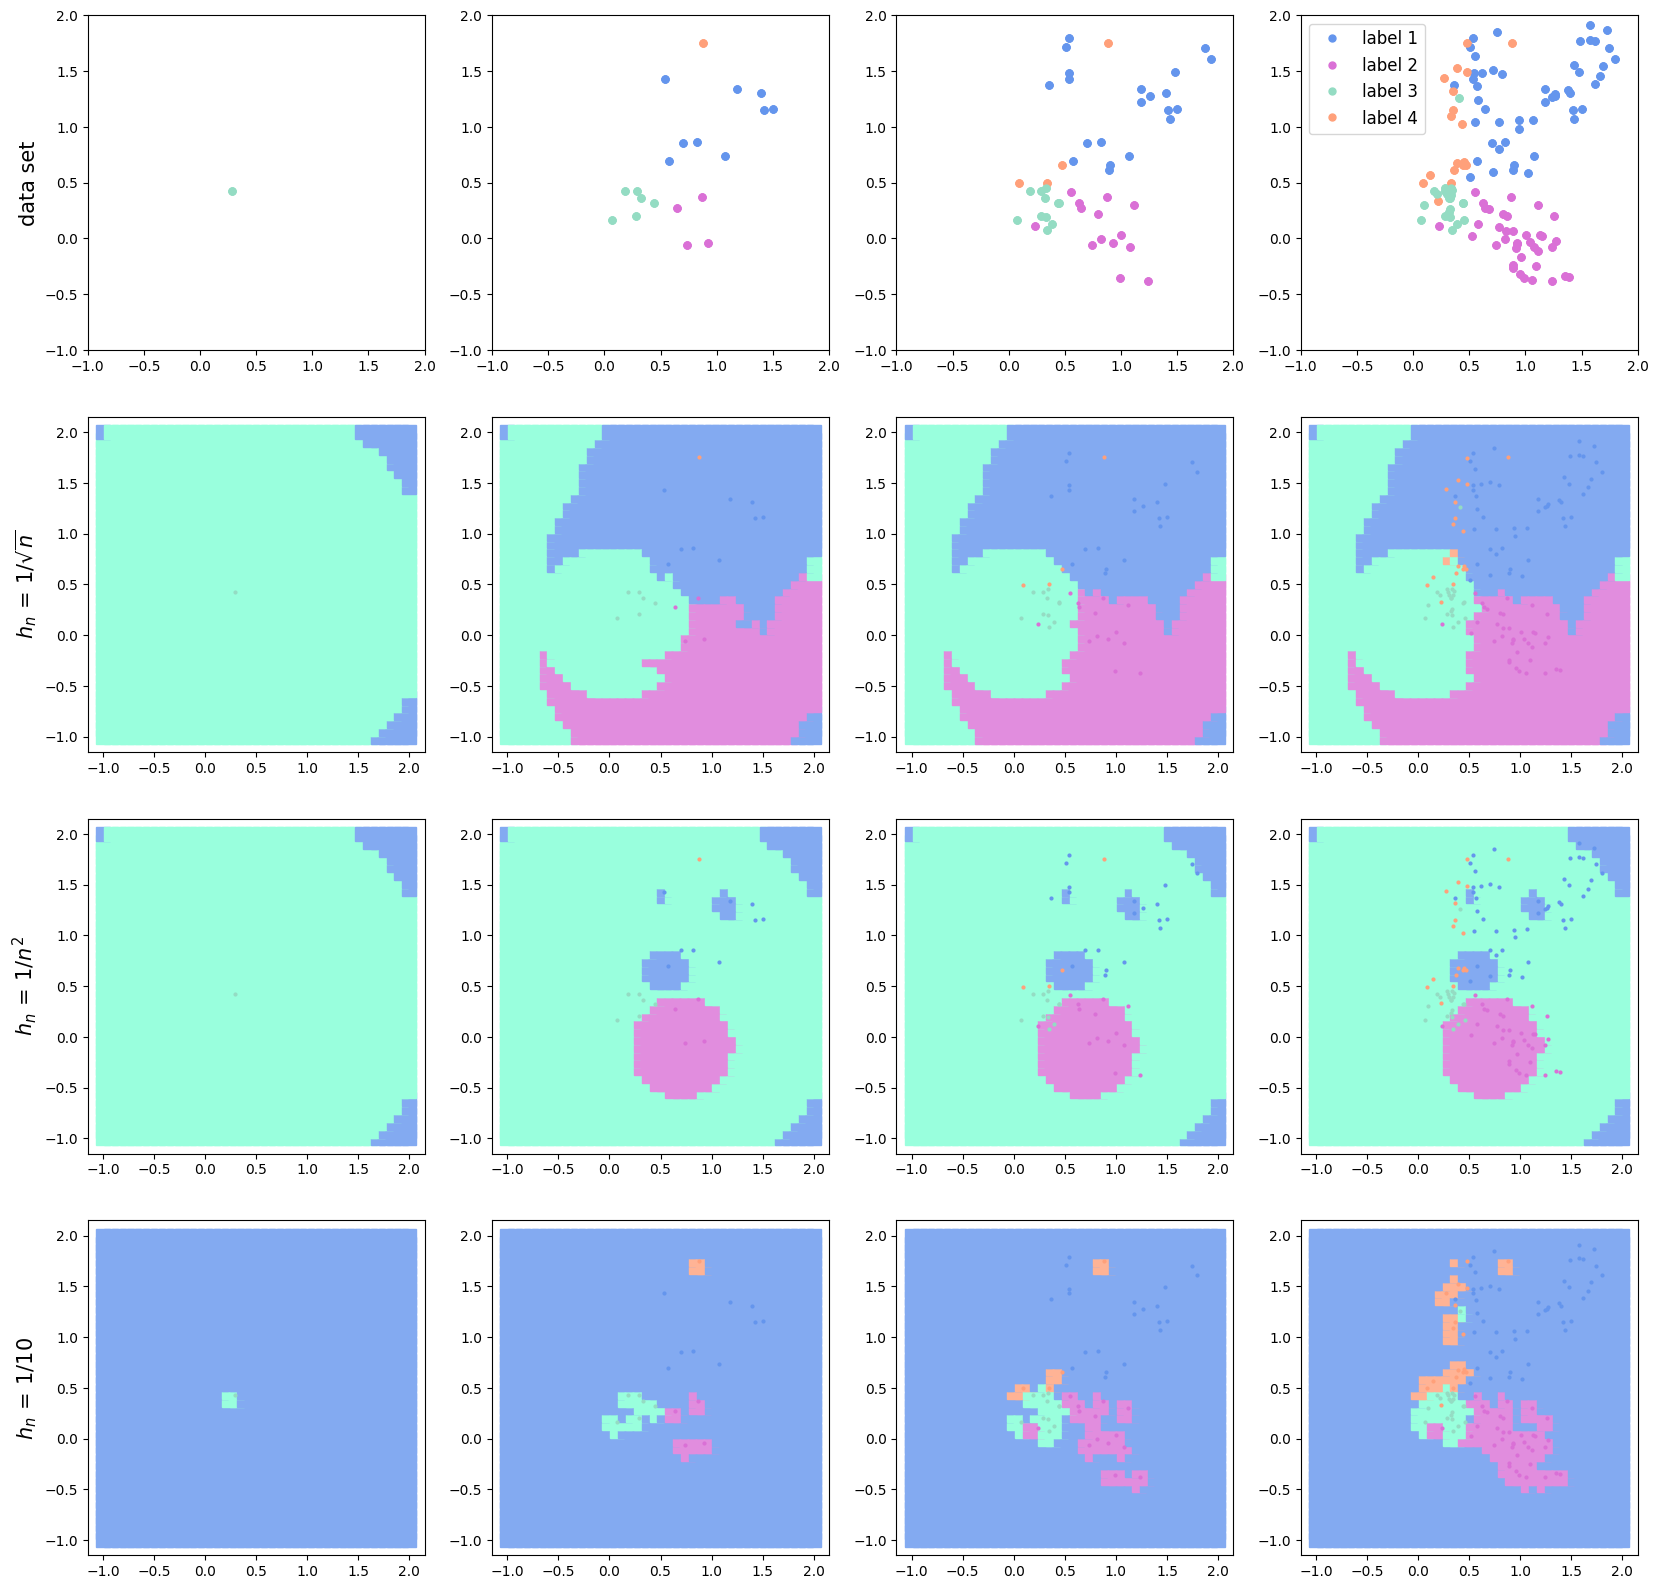

In [502]:
# plot of global solution for different sequences of bandwidths

h = [diverging_series(2), converging_series(2), 0.1*np.ones((n0))]  # three different sequences of bandwidths

fig, axes = plt.subplots(4, len(n))

fig.set_figheight(20)
fig.set_figwidth(len(n)*5)

labels_in_legend = ['_nolegend_', 'label 1', 'label 2', 'label 3', 'label 4'] 
bools_in_legend = [1, 0, 0, 0]

for idy in range(len(n)):

    for idx in range(len(h)):

        x = np.linspace(-1, 2, 40)
        y = np.linspace(-1, 2, 40)
        xx, yy = np.meshgrid(x, y)

        for i in range(len(xx)):
            for j in range(len(yy)):

                # estimate the label of evpoint using the semirecursive kernel estimate for different bandwidths ------------------------

                evpoint = np.copy([xx[i][j],yy[i][j]])
                EVAL = np.zeros((1,m))  # posteriori probabilities 'm_n^(i)' for each label

                for k in labels:
                    DataMOD = np.copy(Data)
                    for l in range(len(DataMOD)):
                        if DataMOD[l, d] == k:
                            DataMOD[l, d] = 1
                        else:
                            DataMOD[l, d] = 0
                    m_n = kernelestimate(evpoint, DataMOD, h[idx], naivekernel, n[idy], 0)
                    EVAL[0, k-1] = m_n
                f_n_star = np.argmax(EVAL[0, :]) 
            
                if f_n_star == 0:
                    axes[idx+1][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('CornflowerBlue', 0.8), markersize=10)
                elif f_n_star == 1:
                    axes[idx+1][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('Orchid', 0.8), markersize=10)
                elif f_n_star == 2:
                    axes[idx+1][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('Aquamarine', 0.8), markersize = 10)
                else:
                    axes[idx+1][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('LightSalmon', 0.8), markersize = 10) 

                # -----------------------------------------------------------------------------------------------------------------------
   
        # plot of the data set ----------------------------------------------------------------------------------------------------------
                
        x = Data[:, 0]
        y = Data[:, 1]
        z = Data[:, 2]

        for i in range(n[idy]):
            if z[i] == 1:
                axes[idx+1][idy].plot(x[i], y[i], 'o', color = lighten_color('CornflowerBlue', 1), markersize = 2)
            elif z[i] == 2:
                axes[idx+1][idy].plot(x[i], y[i], 'o', color = lighten_color('Orchid', 1), markersize = 2)
            elif z[i] == 3:
                axes[idx+1][idy].plot(x[i], y[i], 'o', color = lighten_color('MediumAquamarine', 0.7), markersize = 2)
            else:
                axes[idx+1][idy].plot(x[i], y[i], 'o', color = lighten_color('LightSalmon', 1), markersize = 2)

        for i in range(n[idy]):
            if z[i] == 1:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('CornflowerBlue', 1), markersize = 5, label = labels_in_legend[1*bools_in_legend[0]])
                if idy == 3 and bools_in_legend[0] == 1:
                    bools_in_legend[0] = 0
                    bools_in_legend[1] = 1
            elif z[i] == 2:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('Orchid', 1), markersize = 5, label = labels_in_legend[2*bools_in_legend[1]])
                if idy == 3 and bools_in_legend[1] == 1:
                    bools_in_legend[1] = 0
                    bools_in_legend[2] = 1
            elif z[i] == 3:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('MediumAquamarine', 0.7), markersize = 5, label = labels_in_legend[3*bools_in_legend[2]])
                if idy == 3 and bools_in_legend[2] == 1:
                    bools_in_legend[2] = 0
                    bools_in_legend[3] = 1
            else:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('LightSalmon', 1), markersize = 5, label = labels_in_legend[4*bools_in_legend[3]])
                if idy == 3 and bools_in_legend[3] == 1:
                    bools_in_legend[3] = 0

        # -------------------------------------------------------------------------------------------------------------------------------

for i in range(len(n)):
    axes[0,i].set_xlim(-1, 2)
    axes[0,i].set_ylim(-1, 2)

axes[0,0].set_ylabel('data set', fontsize = 15)
axes[1,0].set_ylabel('$h_n \, = \, 1/\sqrt{n}$', fontsize = 15)
axes[2,0].set_ylabel('$h_n \, = \, 1/n^2$', fontsize = 15)
axes[3,0].set_ylabel('$h_n \, = \, 1/10$', fontsize = 15)

axes[0,3].legend(fontsize = 12)

plt.show()

##### (Weighted) Semirecursive Kernel Estimate

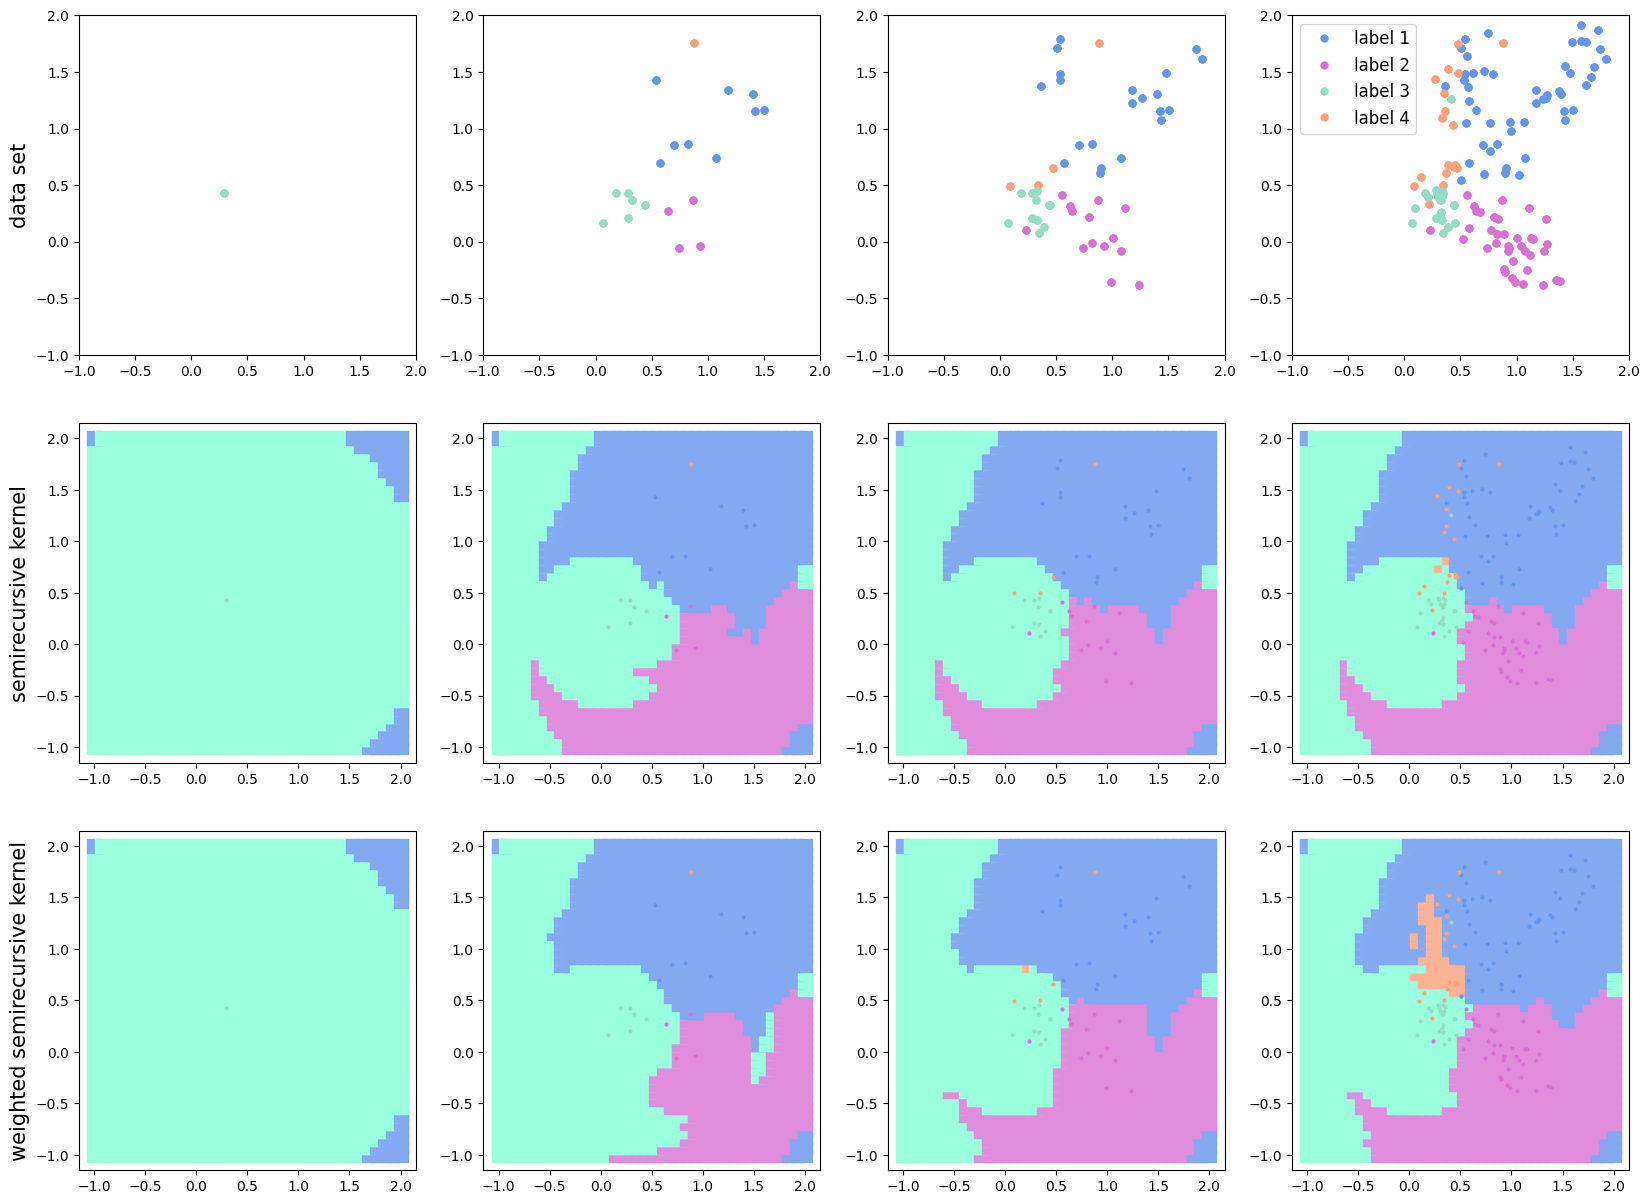

computation time for the semirecursive kernel: 		 18.169 seconds
computation time for the weighted semirecursive kernel:  10.14865 minutes


In [503]:
# plot of global solution for weighted semirecursive kernel estimate

fig, axes = plt.subplots(3, len(n))
 
fig.set_figheight(15)
fig.set_figwidth(len(n)*5)

elapsed_time = np.array([0.0, 0.0])

labels_in_legend = ['_nolegend_', 'label 1', 'label 2', 'label 3', 'label 4']
bools_in_legend = [1, 0, 0, 0]

for idy in range(len(n)):

    x = np.linspace(-1, 2, 40)
    y = np.linspace(-1, 2, 40)
    xx, yy = np.meshgrid(x, y)

    for i in range(len(xx)):
        for j in range(len(yy)):
                
                for bool in range(2):

                    # estimate the label of evpoint using the (weighted) semirecursive kernel estimate ----------------------------------

                    evpoint = np.copy([xx[i][j],yy[i][j]])
                    EVAL = np.zeros((1,m))  # posteriori probabilities 'm_n^(i)' for each label

                    for k in labels:
                        DataMOD = np.copy(Data)
                        for l in range(len(DataMOD)):
                            if DataMOD[l, d] == k:
                                DataMOD[l, d] = 1
                            else:
                                DataMOD[l, d] = 0

                        start_time = datetime.datetime.now() # start timer

                        m_n = kernelestimate(evpoint, DataMOD, diverging_series(2), naivekernel, n[idy], bool)

                        end_time = datetime.datetime.now()
                        delta = end_time - start_time

                        elapsed_time[bool] = elapsed_time[bool] + int(delta.total_seconds() * 1000) # in miliseconds

                        EVAL[0, k-1] = m_n
                    f_n_star = np.argmax(EVAL[0, :]) 
                
                    if f_n_star == 0:
                        axes[1 + bool][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('CornflowerBlue', 0.8), markersize=10)
                    elif f_n_star == 1:
                        axes[1 + bool][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('Orchid', 0.8), markersize=10)
                    elif f_n_star == 2:
                        axes[1 + bool][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('Aquamarine', 0.8), markersize = 10)
                    else:
                        axes[1 + bool][idy].plot(evpoint[0], evpoint[1], 's', color = lighten_color('LightSalmon', 0.8), markersize = 10)

                    # -------------------------------------------------------------------------------------------------------------------
            
    # plot of the data set --------------------------------------------------------------------------------------------------------------

    x = Data[:, 0]
    y = Data[:, 1]
    z = Data[:, 2]

    for k in range(2):
        
        for i in range(n[idy]):
            if z[i] == 1:
                axes[k+1][idy].plot(x[i], y[i], 'o', color = lighten_color('CornflowerBlue', 1), markersize = 2)
            elif z[i] == 2:
                axes[k+1][idy].plot(x[i], y[i], 'o', color = lighten_color('Orchid', 1), markersize = 2)
            elif z[i] == 3:
                axes[k+1][idy].plot(x[i], y[i], 'o', color = lighten_color('MediumAquamarine', 0.7), markersize = 2)
            else:
                axes[k+1][idy].plot(x[i], y[i], 'o', color = lighten_color('LightSalmon', 1), markersize = 2)

        for i in range(n[idy]):
            if z[i] == 1:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('CornflowerBlue', 1), markersize = 5, label = labels_in_legend[1*bools_in_legend[0]])
                if idy == 3 and bools_in_legend[0] == 1:
                    bools_in_legend[0] = 0
                    bools_in_legend[1] = 1
            elif z[i] == 2:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('Orchid', 1), markersize = 5, label = labels_in_legend[2*bools_in_legend[1]])
                if idy == 3 and bools_in_legend[1] == 1:
                    bools_in_legend[1] = 0
                    bools_in_legend[2] = 1
            elif z[i] == 3:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('MediumAquamarine', 0.7), markersize = 5, label = labels_in_legend[3*bools_in_legend[2]])
                if idy == 3 and bools_in_legend[2] == 1:
                    bools_in_legend[2] = 0
                    bools_in_legend[3] = 1
            else:
                axes[0][idy].plot(x[i], y[i], 'o', color = lighten_color('LightSalmon', 1), markersize = 5, label = labels_in_legend[4*bools_in_legend[3]])
                if idy == 3 and bools_in_legend[3] == 1:
                    bools_in_legend[3] = 0

    # -----------------------------------------------------------------------------------------------------------------------------------

for i in range(len(n)):
    axes[0,i].set_xlim(-1, 2)
    axes[0,i].set_ylim(-1, 2)

axes[0,0].set_ylabel('data set', fontsize = 15)
axes[1,0].set_ylabel('semirecursive kernel', fontsize = 15)
axes[2,0].set_ylabel('weighted semirecursive kernel', fontsize = 15)

axes[0,3].legend(fontsize = 12)

plt.show()

print('computation time for the semirecursive kernel: \t\t', elapsed_time[0]/1000, 'seconds')
print('computation time for the weighted semirecursive kernel: ', (elapsed_time[1]/1000)/60, 'minutes')